In [1]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

from dataset import CUBDataset, FGVCAircraft, FOODDataset
from torchvision.transforms import v2
from torch.utils.data import ConcatDataset 
import torch
from torch.utils.data import default_collate

from matplotlib import pyplot as plt


from models.model import get_model
from utils import load_model

In [2]:
transforms_test = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224), antialias=True),
        v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    ])

dataset_path = "/apps/local/shared/CV703/datasets/CUB/CUB_200_2011"


test_dataset = CUBDataset(image_root_path=dataset_path, transform=transforms_test, split="test")

class_names = test_dataset.classes

In [3]:
image, label = test_dataset[1]
print("Image Shape:", image.shape)

Image Shape: torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


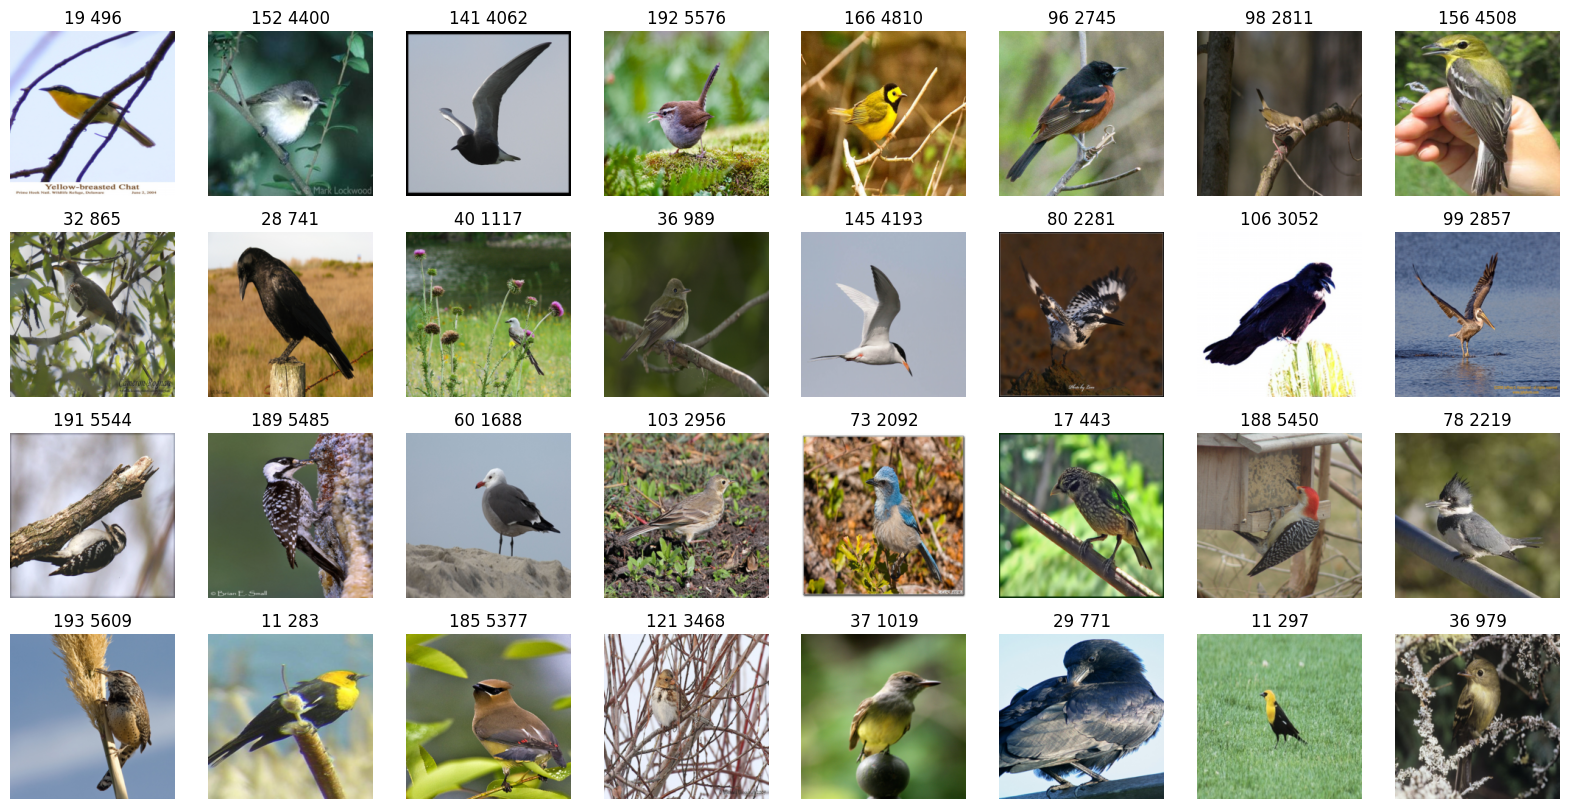

In [10]:
# show some images
# random select 32 images
# np.random.seed(0)
indices = np.random.randint(0, len(test_dataset), size=32)

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    image, label = test_dataset[indices[i]]
    image = image.permute(1, 2, 0)
    # remove normalization
    image = image * torch.tensor([0.229,0.224,0.225]) + torch.tensor([0.485,0.456,0.406])
    ax.imshow(image)

    # label = label.item()
    # label = class_names[label]
    label = str(label) + " " + str(indices[i])
    ax.set_title(label)
    ax.axis('off')
plt.show()

In [5]:
dataset_name = "CUB"
model_name = "ConvNeXtBase"

model = get_model("ConvNeXtBase", pretrained=False, num_classes=200)
run_name = "2024-01-18_17-24-59"

weights_path = f"runs/{dataset_name}/{model_name}/{run_name}/best_model.pth"

model = load_model(model, weights_path)
model.eval();

(-0.5, 223.5, 223.5, -0.5)

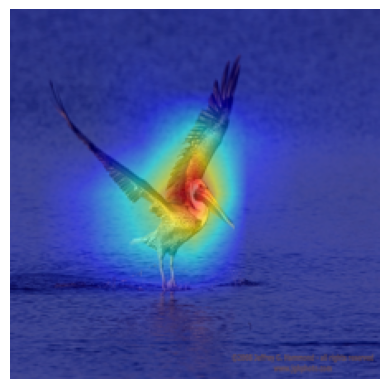

In [16]:
idx = 2857

image, label = test_dataset[idx]
img = image.permute(1, 2, 0).numpy()
img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
img = np.clip(img, 0, 1)
image = image.unsqueeze(0)

targets = [ClassifierOutputTarget(label)]
target_layers = [model.features[6], model.features[7]]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=image, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

plt.imshow(cam_image)
plt.axis('off')

# plt.imshow(img)

In [26]:
model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
# print(len(targets[0]))
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

TypeError: object of type 'ClassifierOutputTarget' has no len()